In [1]:
library(Seurat)
library(data.table)
library(stringr)
# library(MAST)
library(ggplot2)
# library(monocle3)
# library(dplyr)

Loading required package: SeuratObject

Loading required package: sp

‘SeuratObject’ was built with package ‘Matrix’ 1.6.5 but the current
version is 1.7.1; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t




In [2]:
fn = function(p, no.legend=T) {
    lx = unlist(lapply(p$patches$plots, function(x) {ggplot_build(x)$layout$panel_scales_x[[1]]$range$range}))
    ly = unlist(lapply(p$patches$plots, function(x) {ggplot_build(x)$layout$panel_scales_y[[1]]$range$range}))
    p = p & theme(panel.grid=element_line(colour="grey", size=0.5)) & xlim(min(lx), max(lx)) & ylim(min(ly), max(ly)) 
    if (no.legend) p = p & NoLegend()
    return(p)
}

In [3]:
path2root = "/home/xinyuelu/AD-proj/results"
path2figdir = file.path(path2root, 'figures-annotate-hPFC')
path2resdir = file.path(path2root, 'results-annotate-hPFC')
print(path2figdir)
print(path2resdir)

[1] "/home/xinyuelu/AD-proj/results/figures-annotate-hPFC"
[1] "/home/xinyuelu/AD-proj/results/results-annotate-hPFC"


In [4]:
if (!dir.exists(path2figdir)) {
  dir.create(path2figdir)
  print("Directory created")
} else {
  print("Directory already exists")
}

if (!dir.exists(path2resdir)) {
  dir.create(path2resdir)
  print("Directory created")
} else {
  print("Directory already exists")
}

[1] "Directory already exists"
[1] "Directory already exists"


# Load GAGE-seq

In [5]:
path2root = "/home/xinyuelu/AD-proj/results"
path2datadir = file.path(path2root, 'results', 'merged_data')
path2metadir = file.path(path2root, 'results', 'hPFC-lib-all') 
path2figdir = file.path(path2root, 'figures-annotate-hPFC')
path2resdir = file.path(path2root, 'results-annotate-hPFC')

In [6]:
lib_name <- "hPFC-lib-all"
species <- "hg38"

In [7]:
data_dir <- file.path(path2datadir, 
                paste0("RNA_", lib_name, "_10x"))
matrix_file <- file.path(data_dir, "matrix.mtx")
features_file <- file.path(data_dir, "genes.tsv")
barcodes_file <- file.path(data_dir, "barcodes.tsv")

matrix <- Matrix::readMM(matrix_file)  
features <- read.delim(features_file, header = FALSE, stringsAsFactors = FALSE)
barcodes <- read.delim(barcodes_file, header = FALSE, stringsAsFactors = FALSE)

In [8]:
rownames(matrix) <- make.unique(features$V2)
colnames(matrix) <- barcodes$V1  

In [9]:
options(future.globals.maxSize = 1e11)

In [10]:
obj.gage <- CreateSeuratObject(counts = matrix, project = "hPFC-lib-all", min.cells = 10)
df_meta = read.csv(
    file.path(path2metadir, 
    paste0("meta_", lib_name, "_human_hg38.csv")), 
    header = TRUE, row.name = 1, sep = ",",
)
print(dim(df_meta))
stopifnot(all.equal(colnames(obj.gage), rownames(df_meta)))

Warning message:
“Data is of class dgTMatrix. Coercing to dgCMatrix.”


[1] 30557   201


In [11]:
obj.gage = AddMetaData(obj.gage, df_meta)
obj.gage = AddMetaData(obj.gage, metadata='GAGE-seq', col.name='dataset')
obj.gage = AddMetaData(obj.gage, metadata=obj.gage$batch, col.name='dataset2')
obj.gage

An object of class Seurat 
43229 features across 30557 samples within 1 assay 
Active assay: RNA (43229 features, 0 variable features)
 1 layer present: counts

In [12]:
w = 12
h = 8
saved <- options(repr.plot.width=w, repr.plot.height=h)
p <- FeatureScatter(obj.gage, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") +
    theme_classic() +
    ggtitle("Pearson correlation = 0.89")
path2file <- file.path(path2figdir, "RNA_feature_scatter_pearson.png")
ggsave(path2file, p, width=w, height=h)
options(saved)

In [13]:
num_pcs = 50
num_nbrs = 20

In [14]:
DefaultAssay(obj.gage) <- "RNA"
obj.gage <- NormalizeData(obj.gage, verbose=F)
obj.gage <- FindVariableFeatures(obj.gage, verbose=F)
obj.gage <- ScaleData(obj.gage, verbose=F)
obj.gage <- RunPCA(obj.gage, verbose=F, npcs = num_pcs)

In [15]:
obj = obj.gage

obj <- FindNeighbors(
    obj, dims=1:num_pcs, k.param=num_nbrs, verbose=F,
    annoy.metric='euclidean'
)
obj <- FindClusters(obj, resolution=1, n.start=100, n.iter=100, verbose=F)
obj[['raw.ident']] <- Idents(obj)
obj <- RunUMAP(obj, verbose=F, dims=1:num_pcs, min.dist=.1, n.neighbors=num_nbrs, metric='correlation')

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


In [16]:
w = 20
h = 12
saved <- options(repr.plot.width=w, repr.plot.height=h)
p <- DimPlot(obj, label=F, repel=T, label.size=5, group.by='batch') +
DimPlot(obj, label=F, repel=T, label.size=5, group.by='condition') +
DimPlot(obj, label=F, repel=T, label.size=5, group.by='sex') +
DimPlot(obj, label=F, repel=T, label.size=5, group.by='sample_id') +
DimPlot(obj, label=T, repel=T, label.size=5)
path2file <- file.path(path2figdir, "UMAP_RNA-Seurat-raw.png")
ggsave(path2file, p, width=w, height=h)
options(saved)

In [17]:
path2file = file.path(path2resdir, paste0("UMAP_RNA-Seurat-wd_", lib_name, "-raw.csv"))
print(path2file)
write.csv(data.frame(obj[["umap"]]@cell.embeddings), path2file)

path2file = file.path(path2resdir, paste0("meta-Seurat-wd_", lib_name, "-raw.csv"))
print(path2file)
write.csv(data.frame(Idents(obj)), path2file)

# obj.gage = obj

[1] "/home/xinyuelu/AD-proj/results/results-annotate-hPFC/UMAP_RNA-Seurat-wd_hPFC-lib-all-raw.csv"
[1] "/home/xinyuelu/AD-proj/results/results-annotate-hPFC/meta-Seurat-wd_hPFC-lib-all-raw.csv"


In [19]:
head(df)

,orig.ident,nCount_RNA,nFeature_RNA,DNA.coverage.all,DNA.coverage.all.chr16,DNA.coverage.all.chrX,DNA.coverage.all.chr17,DNA.coverage.all.chr20,DNA.coverage.all.chr19,DNA.coverage.all.chr18,⋯,RNA.coverage..mito,RNA.species,DNA.species,species,batch,sample_id,sex,condition,dataset,dataset2
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>
"hPFC-lib-1_A1,A7",hPFC-lib-1,4495,1258,64012,1311.5,3013.5,1337.5,1291.0,515.5,1982.5,⋯,0.006451613,hg38,hg38,hg38,hPFC-lib-1,21272396,Female,CT,GAGE-seq,hPFC-lib-1
"hPFC-lib-1_A1,C5",hPFC-lib-1,3582,1116,303281,5662.5,8227.0,6490.0,4778.0,2766.0,8379.0,⋯,0.003070910,hg38,hg38,hg38,hPFC-lib-1,66754397,Male,AD,GAGE-seq,hPFC-lib-1
"hPFC-lib-1_A1,C8",hPFC-lib-1,6806,1685,429266,8691.5,11564.5,9076.5,7904.5,4953.5,12643.0,⋯,0.002200704,hg38,hg38,hg38,hPFC-lib-1,66754397,Male,AD,GAGE-seq,hPFC-lib-1
"hPFC-lib-1_A1,C10",hPFC-lib-1,24630,4386,451607,9923.0,12536.5,10298.5,8158.5,5018.0,14031.0,⋯,0.012946954,hg38,hg38,hg38,hPFC-lib-1,66754397,Male,AD,GAGE-seq,hPFC-lib-1
"hPFC-lib-1_A1,C12",hPFC-lib-1,11859,2334,149474,2839.0,3947.5,2939.5,2614.5,1462.0,4921.5,⋯,0.001939455,hg38,hg38,hg38,hPFC-lib-1,66754397,Male,AD,GAGE-seq,hPFC-lib-1
"hPFC-lib-1_A1,D2",hPFC-lib-1,10160,1993,78132,1376.0,2138.0,1488.0,1187.5,577.0,2140.0,⋯,0.002165354,hg38,hg38,hg38,hPFC-lib-1,66754397,Male,AD,GAGE-seq,hPFC-lib-1


In [22]:
df = obj.gage[[]]
write.csv(table(df['sample_id']), file = "sample_id.csv", row.names = FALSE)

In [24]:
# Create a table summarizing sample_id and condition counts
summary_table <- as.data.frame(table(df$sample_id, df$condition))

# Rename columns for better clarity
colnames(summary_table) <- c("sample_id", "condition", "count")

summary_table

# # Write the summary table to a CSV file
# write.csv(summary_table, file = "sample_id_condition_summary.csv", row.names = FALSE)


sample_id,condition,count
<fct>,<fct>,<int>
10291856,AD,0
10383017,AD,0
12365619,AD,1148
20780035,AD,1357
21272396,AD,0
23690880,AD,0
37030589,AD,0
37178462,AD,0
50403446,AD,2891


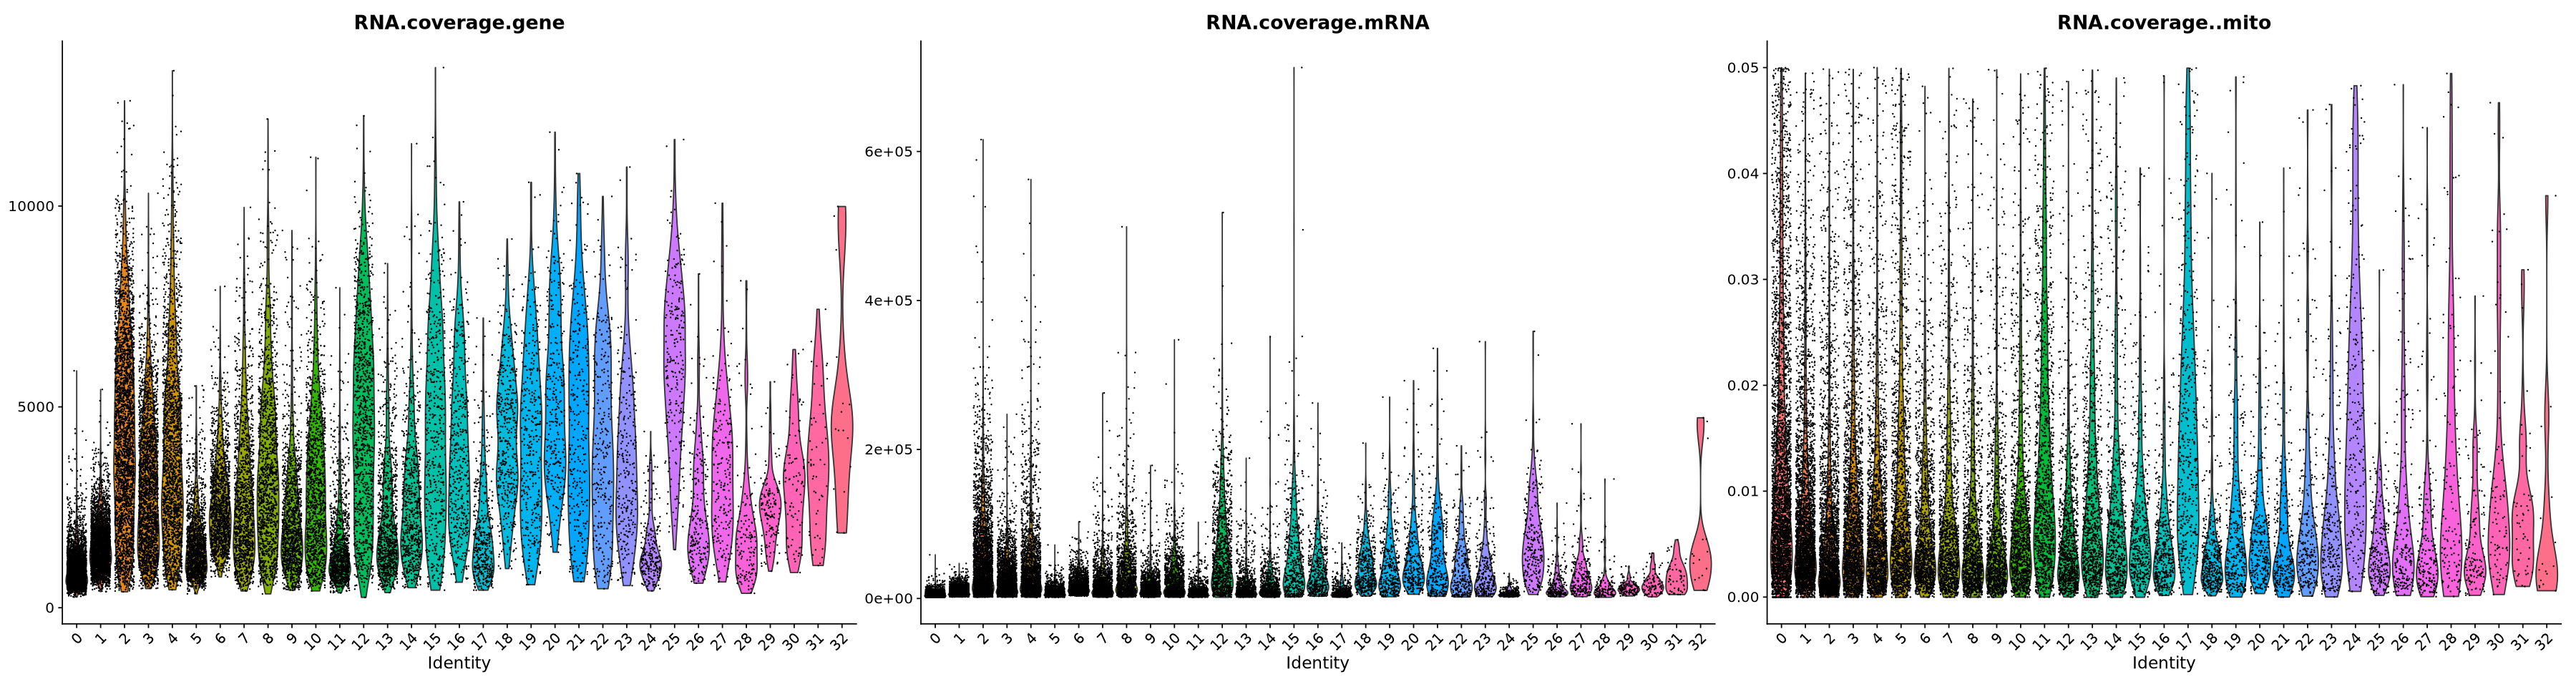

In [25]:
saved <- options(repr.plot.width=30, repr.plot.height=8)
print(VlnPlot(obj, c('RNA.coverage.gene', 'RNA.coverage.mRNA', 'RNA.coverage..mito')))
options(saved)
obj.gage = obj